# Custom models and its evaluation

This practice purposed to cover 3 technical topics using theoretical framework, you met on lections, but not only.

These topics are:

1.   Custom goal function and its optimization (using MAPE as example).
2.   Preprocessing pipelines (using polynomial features as example).
3.   Hyper-parameters tuning using Cross-validation.

All examples are made with the same artificial regression data. I encourage you to try it on your dataset and also classification task!


### Possible tasks

0. Make your own implementation of Cross-Validation procedure.
1. Implement L1 and L2 (or Lp) regularization for polynomial regression and use Cross-Validation to find optimal regularization method and coefficient 
2. Use regularization for to reduce number of features in polynomial regression 
3. Implement your own loss and objective function 
4. Implement weighted linear regression and use cross-validation to find optimal $\sigma$ parameter
5. Remade the whole document to solve classification task 

Any experiments will be appreciated and evaluated.

In [49]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

In [51]:
# Generate nonlinear data with outliers.
# Don't hesitate to change the generation parameters, method and data itself! Observe, how it changes results

n_samples = 1000
n_outliers = 100

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=True, random_state=1110)


print(coef)

6.52469309972703


In [52]:
print(X.shape)

(1000, 1)


In [53]:
print(y.shape)

(1000,)


In [54]:
# Replace first N samples with outliers

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

In [55]:
# Add non-linearity to data

y = y+100*X.T[0]*np.sin(X.T[0])


In [56]:
# Scale data to put in range [0,1] for stability.
# Check results if ignore it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())


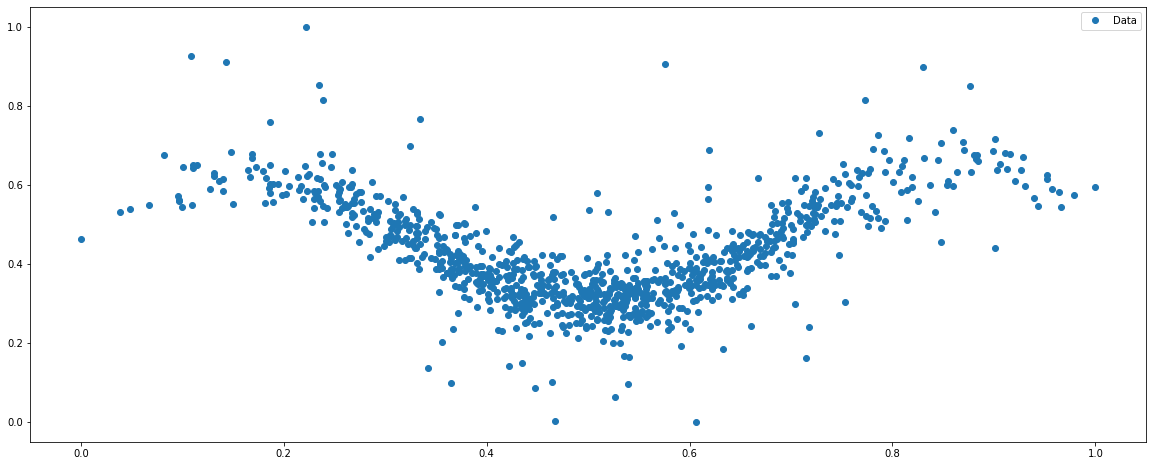

In [57]:
#visualize data
plt.plot(X, y, 'o', label = 'Data')
plt.legend()

In [58]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

## Define Model

### Mean Absolute Percentage Error (MAPE)

Let's use [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a custom error function:

$$ \text{MAPE} = \frac{1}{n}\sum_i \left| \frac{y_i - \hat{y_i}}{y_i} \right| \cdot 100\%$$

This function uses percentage ratio between error and original value to express forecast accuracy, which is much more interpretable, than absolute error. 

You can try your loss function here! Figure out something or google anything like 'Best regression loss function'. The only what matters is to take y_true and y_pred on input and return single value.

In [59]:
def mape(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape_value

In [72]:
def mse(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    
    mse_value = np.mean(np.power(y_true - y_pred, 2))
    return mse_value

In [85]:
def rmse(y_true, y_pred):
    rmse_value = np.sqrt(mse(y_true, y_pred))
    return rmse_value

In [89]:
def made(y_true, y_pred):
    made_value = np.mean(np.abs(y_true - y_pred))
    return made_value

In [86]:
yy=np.random.random(len(y))

### Сoncatenate into table values of random prediction for different loss functions 

In [104]:
import pandas as pd
erors = {'Value': [mse(y, yy), rmse(y, yy) , made(y, yy), mape(y, yy)],
        'Type': ['absolute error','absolute error','absolute error', 'percentage error']}

df = pd.DataFrame(erors, columns = ['Value','Type' ], index=['MSE','RMSE', 'MADE', 'MAPE'])
print(df)


          Value              Type
MSE    0.104077    absolute error
RMSE   0.322610    absolute error
MADE   0.268401    absolute error
MAPE  78.553927  percentage error


In [93]:
print('Error of random prediction: %.5f'%mse(y, yy) )

Error of random prediction: 0.10408


In [94]:
print('Error of random prediction: %.5f'%rmse(y, yy) )

Error of random prediction: 0.32261


In [95]:
print('Error of random prediction: %.5f'%made(y, yy) )

Error of random prediction: 0.26840


In [96]:
print('Error of random prediction: %.5f%%'%mape(y, yy) )

Error of random prediction: 78.55393%


In [7]:
def predict(X, theta):
    return np.dot(X, theta)

In [8]:
print('Error of random model: %.2f%%'%mape(y, predict(X_I, theta = np.random.random(len(X_I[0])))))

Error of random model: 17.22%


Define objective (goal) function as simple as
$L(\theta|X,y) = MAPE(y, h(\theta|X))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

In [9]:
def objective_function(theta, X,y, loss_function=mape):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)

Visualize objective function surface

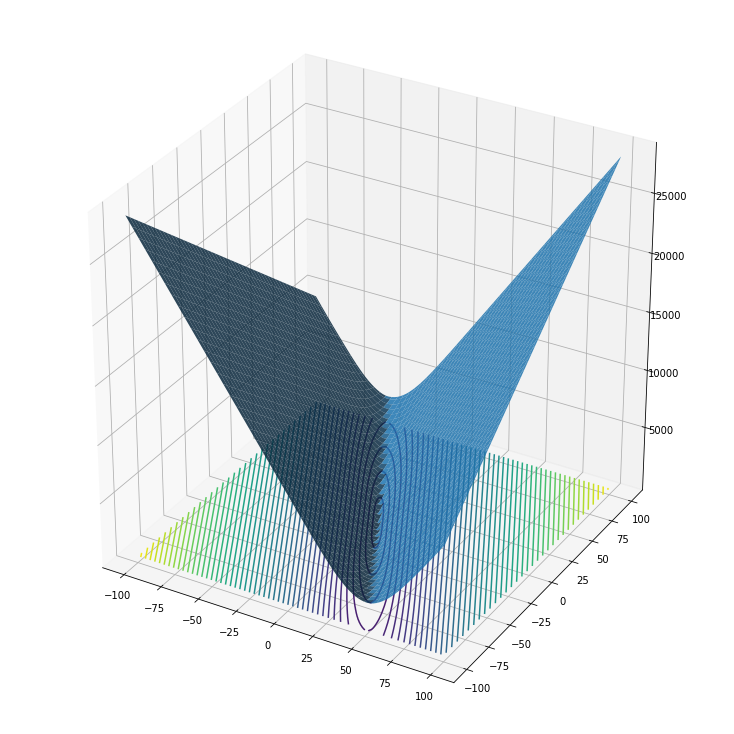

In [10]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b,w]), X_I, y, mape) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# create 2d array for each index 
K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

## Train model

We're done with defining gradient descent step manually!

There are less efficient but more universal approaches, for example use numerical optimization methods. 

Let's try [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [11]:
from scipy import optimize

In [12]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, mape), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )

In [13]:
result

   direc: array([[ 0.53425275, -0.92205993],
       [ 0.00920321, -0.02469735]])
     fun: 15.68065264945494
 message: 'Optimization terminated successfully.'
    nfev: 187
     nit: 5
  status: 0
 success: True
       x: array([ 0.54309176, -0.07475327])

Optimization results come in the special object. Here what we are interested in:

In [14]:
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 15.68065264945494
Found theta: [ 0.54309176 -0.07475327]


The most common reason of optimization fail is _'Desired error not necessarily achieved due to precision loss'_. It means, that on some point the procedure became numerically unstable, usually because of too big or too small values of objective function. 

If this point wasn't too close, results are still usable. 

There is also some chance to make result better with changing _theta_init_  or just re-running the function, and, the most reliable, change optimization method's options and method itself.

Also normalizing data is always useful.

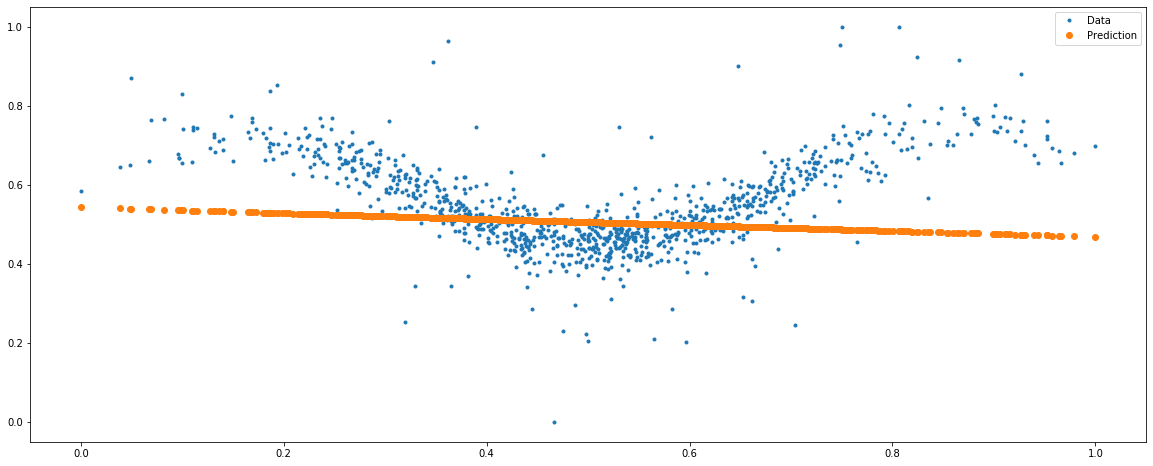

In [15]:
# Visualize result
theta = result.x
y_pred = predict(X_I, theta)
plt.plot(X, y, '.', label = 'Data')
plt.plot(X, y_pred, 'o', label = 'Prediction')
plt.legend()

In [16]:
# For further use, let's make universal function to train regression model with any objective and loss functions

def custom_regression(X, y, 
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init = 1, 
                      verbose = True, 
                      iters = 10):
  
  theta_init = np.ones_like(X[0]) * init
  result = optimize.minimize(objective_function,
                             args=(X, y, loss_function), 
                             x0 = theta_init, 
                             method='BFGS', 
                             options={'maxiter': iters})
  theta = result['x']
  if verbose:
    print(result['fun'])
  return theta

## Add polynomial features

In [17]:
from sklearn.preprocessing import PolynomialFeatures

n = 10 # power of polynom
polynomial_features = PolynomialFeatures(degree=n,include_bias=True) # create instance of preprocessor
X_a = polynomial_features.fit_transform(X) # apply transformation
X_a.shape

(1000, 11)

In [18]:
theta = custom_regression(X_a, y, objective_function=objective_function, loss_function=mape)

8.682466588436402


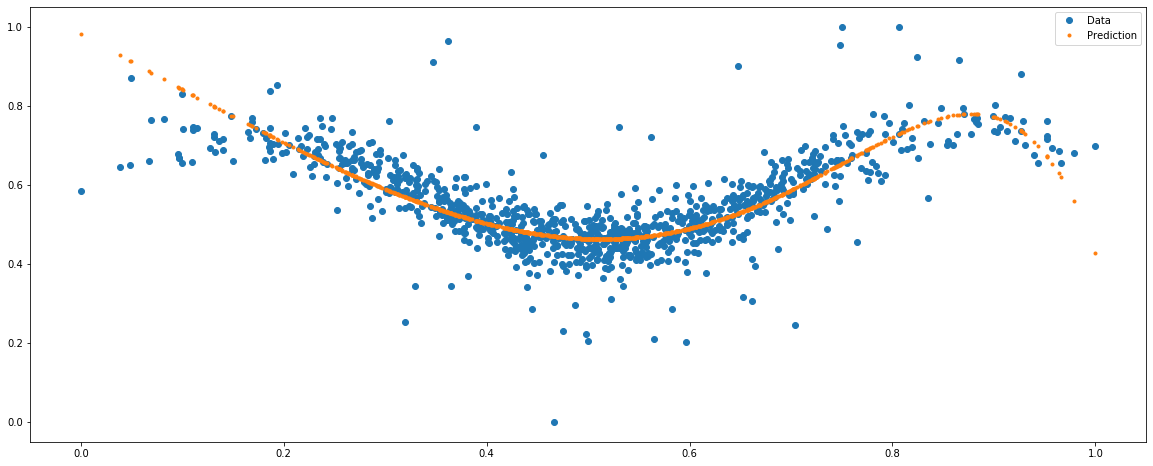

In [19]:
y_pred = predict(X_a, theta)
plt.plot(X, y, 'o', label = 'Data')
ax = plt.gca()
ax.autoscale(enable = True)
plt.plot(X, y_pred, '.', label = 'Prediction')
plt.legend()

In [20]:
degrees = [1,2,5,10,25,50,500]

In [21]:
from sklearn.model_selection import train_test_split

# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

15.168735257495744
9.811989361881361
8.101048077197012
8.427147041173951
8.3530048766557
8.352523909536382
8.911637681150395
Wall time: 1.97 s


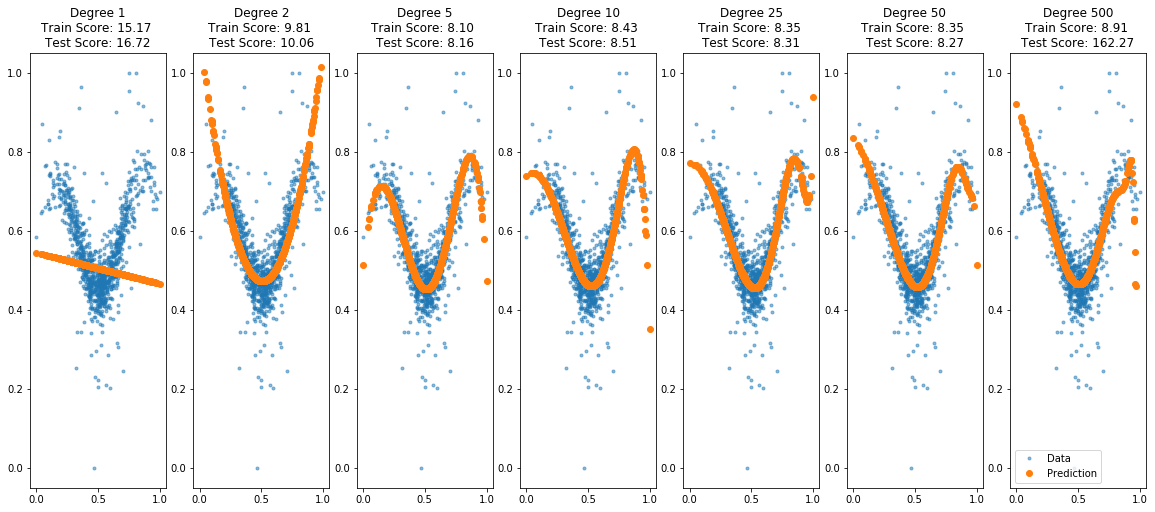

In [22]:
%%time
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree=n,include_bias=True)
  
  # make transformation of all data subsets
  X_all = polynomial_features.fit_transform(X)
  X_a_train = polynomial_features.fit_transform(X_train)
  X_a_test = polynomial_features.fit_transform(X_test)
  
  # train model
  theta = custom_regression(X_a_train, y_train, objective_function=objective_function, loss_function=mape, iters = 20)
  
  # test model
  y_pred_test = predict(X_a_test, theta)
  y_pred_train = predict(X_a_train, theta)
  test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
  train_score = objective_function(theta=theta, X=X_a_train, y=y_train)
  
  #visualize results
  y_pred = predict(X_all, theta)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(X, y_pred, 'o', label = 'Prediction')
  plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))
plt.legend()

## Evaluate result

To make convenient and safe using of our approach (preprocessing + modelling) we can use great sklearn tool called [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators).

Pipeline can include any number of data transformations and modelling, and than be treated as a single sklearn object.

To make it possible, all models of sklearn inherits the same interface, which essentialy should have just few methods:
* ```__init__()```, that should be able to be called without arguments and create an instance with no dependencies to data.
* ```fit()```, that takes data and make all data-dependent actions (transformations or training). Main logic is here. 
* ```predict()``` (for models) or ```transform()``` (for preprocessing) to process a new data after fitted

Optionally, we can use ```score()``` which take true data and return single value to evaluate quality of the model. It is used to make cross-validation and other model selection procedures.

Finally, methods ```fit_transform()``` or ```fit_predict()``` are not essential, but commonly used and just make fit and transform (or predict) on the same data data in one step.




In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 

Sklearn has one basic class ```BaseEstimator``` for all objects and few inherited specials for particular tasks, like ```ClassifierMixin```, ```RegressorMixin``` and ```TransformerMixin```. Inheriting them we can be sure that we have all non-essential but useful methods, like ```set_value```, ```get_value``` etc, and also tell Pipelines how to treat our object.

In [24]:
class CustomRegression(BaseEstimator, RegressorMixin):                           
  def __init__(self, loss_function=mape, objective_function=objective_function): # all arguments should have default values
    self.theta = None # we don't know shape of theta on this stage
    # just save all variables taken during call to internal variables
    self.loss_function = loss_function 
    self.objective_function = objective_function
    
  def predict(self, X):
    return predict(X, self.theta)
  
  def score(self, X, y):
    return self.objective_function(theta=self.theta, X=X,y=y,loss_function=self.loss_function)
  
  def fit(self, X, y):
    if type(self.theta) == type(None):
      self.theta = np.ones_like(X[0])
    else:
      assert self.theta.shape == X[0].shape, "Model's shape doesn't fit input shape"
    self.theta = custom_regression(X, y, self.objective_function, self.loss_function, init = self.theta, verbose = False)
    return self.score(X, y)
  
  def fit_predict(self, X, y):
    self.fit(X,y)
    return self.predict(X)
     

Use the class with Pipeline

Wall time: 11.7 s


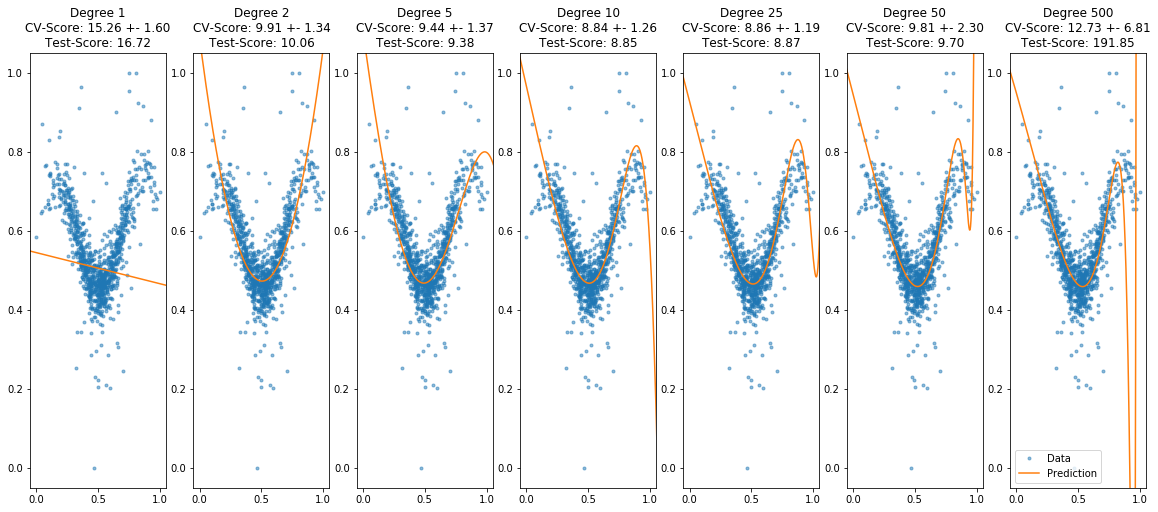

In [25]:
%%time
results = {}
row_results = {}
for i,n in enumerate(degrees):
  polynomial_features = PolynomialFeatures(degree = n) # create instance of transformer
  regression = CustomRegression() # create instance of model

  # make pipeline as list of pairs (<stage name>, <stage object>):
  pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression
  
  # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
  pipeline.fit(X_train, y_train)

  # Evaluate pipeline using crossvalidation and score() method
  scores = cross_val_score(pipeline, X_train, y_train, cv=10)
  
  # Make single evaluation on test set
  test_scores = pipeline.score(X_test, y_test)

  # Save results
  results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
  row_results[n] = scores

  # Plot results
  line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
  line_y = pipeline.predict(line_x)
  
  ax = plt.subplot(1, len(degrees), i + 1)
  ax.plot(X, y, '.', alpha = 0.5, label = 'Data')
  ax.autoscale(enable = False)
  ax.plot(line_x, line_y, '-', label = 'Prediction')
  plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'],results[n]['CV_std'],results[n]['Test']))
  
plt.legend()

In [26]:
# simple way to see best runs
import pandas as pd
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,Test
1,15.257165,1.599970,16.718788
2,9.910636,1.341226,10.059601
5,9.442360,1.373219,9.376951
10,8.843480,1.264994,8.845598
25,8.860083,1.187695,8.865773
50,9.806016,2.303838,9.702610
500,12.728129,6.808675,191.851575


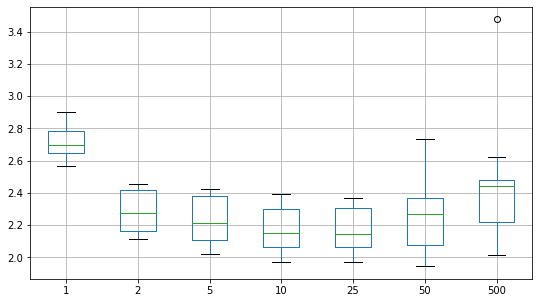

In [30]:
# simple way to visualize model's quality and stability
# using log because of possibly huge outliers on high degrees. Remove it, if everything is  ok.
pd.DataFrame(row_results).apply(np.log).boxplot(figsize = (9,5))

Analyze results and describe proper way to chose model (be carefull, there is intentional error in the last procedure with cross-validation)